In [2]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model 
from keras.utils import to_categorical


Using TensorFlow backend.


Read the data
===========

In [6]:
x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')

# x_original=x_original[['Unnamed: 0','S000501', 'S000502', 'S000300', 'SEX', 'L190400', 'L190300', 'L190500', 'L100700',
#                        'L103300', 'L103000', 'L100800', 'L100500', 'S000100', 'L101700', 'L101300', 'L101600',
#                        'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_29', 'FIELD_41', 'FIELD_27',
#                        'FIELD_42', 'FIELD_21', 'AGE'
# #                       'FIELD_7', 'FIELD_6', 'FIELD_5',
#                       ]]

# y_original=y_original[['Unnamed: 0','S000501', 'S000502', 'S000300', 'SEX', 'L190400', 'L190300', 'L190500', 'L100700',
#                        'L103300', 'L103000', 'L100800', 'L100500', 'S000100', 'L101700', 'L101300', 'L101600',
#                        'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_29', 'FIELD_41', 'FIELD_27',
#                        'FIELD_42', 'FIELD_21', 'AGE'
# #                       'FIELD_7', 'FIELD_6', 'FIELD_5',
#                       ]]


x_original=x_original[['Unnamed: 0','S000501','S000502','S000300','SEX','L190300','L190400','L190500','L100700','L103300',
'L100500','S000100','L100800','L103000','L101700','L101300','FIELD_33','L101600','FIELD_38','AGE' 
                      ]]

y_original=y_original[['Unnamed: 0','S000501']]

print(x_original.shape)
print(y_original.shape)


(159381, 20)
(159381, 2)


In [7]:
for index,col in enumerate(x_original.columns):
    print(col,x_original[col].dropna().shape[0])

Unnamed: 0 159381
S000501 159305
S000502 159305
S000300 159075
SEX 159381
L190300 159204
L190400 159241
L190500 159204
L100700 152474
L103300 135222
L100500 158954
S000100 159302
L100800 159236
L103000 158939
L101700 158951
L101300 159247
FIELD_33 159069
L101600 152251
FIELD_38 159077
AGE 159381


Prepare the data
============

In [8]:
df=x_original.copy()
conditions = [
    (df.S000501 < 120)  ,
    (df.S000501 >= 120) & (df.S000501 < 130),
    (df.S000501 >=130)]
choices = [0,1,2]
df['sbpG'] = np.select(conditions, choices, default=0)
df.head()
x_original=df.copy()

conditions2 = [
    (df.S000502 < 80)  ,
    (df.S000502 >= 80) & (df.S000502 < 90),
    (df.S000502 >=90)]
choices2 = [0,1,2]
df['dbpG'] = np.select(conditions2, choices2, default=0)
df.head()
x_original=df.copy()

conditions3 = [
    (df.AGE < 30)  ,
    (df.AGE >= 30) & (df.AGE < 40),
    (df.AGE >= 40) & (df.AGE < 50),
    (df.AGE >= 50) & (df.AGE < 60),
    (df.AGE >= 60)]
choices3 = [0,1,2,3,4]
df['AgeG'] = np.select(conditions3, choices3, default=0)
df.head()
x_original=df.copy()


conditions4 = [
    (df.L100800 < 100)  ,
    (df.L100800 >= 100) & (df.L100800 < 126), 
    (df.L100800 >= 126)]
choices4 = [0,1,2]
df['CLASS'] = np.select(conditions4, choices4, default=0)
df.head()
x_original=df.copy()

In [9]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.dropna(). reset_index()

# data=data[data.AGE_x >= 40]
# data=data[data.AGE_x < 50]

# data=data[data.CLASS_x==0]
# data=data[data.sbpG==0]
# data=data[data.dbpG==0]

# data=data[data.L100800_y <200]

print(data.shape)

(128460, 26)


In [10]:
print(data.shape)
print(data.columns)
data.head()

(128460, 26)
Index(['index', 'Unnamed: 0', 'S000501_x', 'S000502', 'S000300', 'SEX',
       'L190300', 'L190400', 'L190500', 'L100700', 'L103300', 'L100500',
       'S000100', 'L100800', 'L103000', 'L101700', 'L101300', 'FIELD_33',
       'L101600', 'FIELD_38', 'AGE', 'sbpG', 'dbpG', 'AgeG', 'CLASS',
       'S000501_y'],
      dtype='object')


,index,Unnamed: 0,S000501_x,S000502,S000300,SEX,L190300,L190400,L190500,L100700,...,L101300,FIELD_33,L101600,FIELD_38,AGE,sbpG,dbpG,AgeG,CLASS,S000501_y
0,0,0,121.0,67.0,20.1,1.0,4.20,12.3,38.2,3.0,...,8.0,1.0,49.0,1.0,44.0,1,0,2,0,117.0
1,1,1,117.0,76.0,19.7,1.0,4.24,13.1,39.0,3.0,...,9.0,1.0,51.0,1.0,45.0,0,0,2,0,135.0
2,2,2,135.0,82.0,20.2,1.0,4.26,12.9,38.4,3.8,...,10.0,1.0,56.0,2.0,46.0,2,1,2,0,129.0
3,3,3,118.0,71.0,24.8,1.0,4.20,13.5,40.3,3.7,...,12.0,1.0,42.0,0.0,51.0,0,0,3,0,111.0
4,4,4,111.0,65.0,25.5,1.0,3.92,12.6,38.6,3.4,...,12.0,1.0,46.0,0.0,52.0,0,0,3,0,122.0


In [11]:
x=data[['S000501_x','S000502','S000300','SEX','L190300','L190400','L190500','L100700','L103300',
'L100500','S000100','L100800','L103000','L101700','L101300','FIELD_33','L101600','FIELD_38','AGE'
       ]]

y=data[['S000501_y']]

Check the correlation of the selected feature with the independent variables
=====

In [12]:
temppd=pd.DataFrame(x.copy())
temppd['y']=y.S000501_y
temppd.head()
corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

In [13]:
corval.y

y            1.000000
S000501_x    0.665415
S000502      0.571261
S000300      0.444974
SEX          0.378057
L190300      0.353069
L190400      0.351748
L190500      0.345989
L100700      0.341870
L103300      0.287153
L100500      0.276579
S000100      0.275239
L100800      0.264204
L103000      0.261050
L101700      0.246883
L101300      0.238835
FIELD_33     0.208663
L101600      0.197378
FIELD_38     0.181564
AGE          0.157404
Name: y, dtype: float64

In [14]:
#histogram plot of the features
# import matplotlib.pyplot as plt
# x[x.dtypes[(x.dtypes=="float64")|(x.dtypes=="int64")]
#                         .index.values].hist(figsize=[11,11])

Apply PCA
===========

In [15]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [16]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [17]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [18]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

In [19]:
# x.columns

Random Forest Regressor
=============

In [20]:
ylable=y[['S000501_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [21]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=500)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[8.76029950e-01 2.06934272e-02 4.24754273e-02 4.16276785e-02
 9.35850548e-04 9.82993327e-04 9.66691184e-04 1.54681287e-03
 4.99921244e-04 4.58351572e-04 1.09441529e-03 1.28708919e-03
 8.94620118e-04 2.21510917e-03 8.19945646e-04 3.36715964e-05
 8.93227087e-04 3.12468247e-04 6.23235003e-03]


mean_squared_error 81.23227633967993
root mean_squared_error 9.012895003253945
mean_absolute_error 7.151475502823037
r2_score 0.48787270752175904


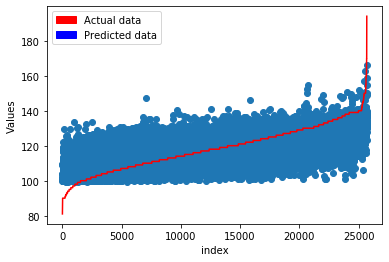

,t + 1,pred (t +1)
23300,170.0,132.360276
8426,170.0,123.052078
7591,173.0,149.068889
23793,175.0,130.084740
132,175.0,136.240752
21357,175.0,138.032195
9649,178.0,133.294920
11878,180.0,137.807436
3147,180.0,137.970689
3719,194.0,166.264334


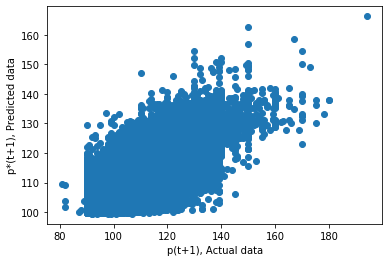

In [22]:

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

In [23]:
# tempdata=pd.DataFrame(xtest.copy())
# tempdata['ytest']=ytest
# # temp=temp.dropna()
# # tempdata.head()
# # tempdata[tempdata.ytest.isna()].index

# tempdata=tempdata.drop(tempdata[tempdata.ytest.isna()].index)


xg boost
==========

In [24]:
import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

In [25]:
xg_reg = xgb.XGBRegressor()
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain) 

[03:05:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [26]:

ypred = xg_reg.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

# ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
# ypredPD['t + 1']=ytest.values
# ypredPD['pred (t +1)']=ypred
# ypredPD.head(10)

mean_squared_error 80.2885208107834
root mean_squared_error 8.96038619763587
mean_absolute_error 7.103183754949615
r2_score 0.4938225957380401


In [138]:
# ytest[ytest.isna()].shape
# tempdata.iloc[:,-1]

ANN
==========

In [141]:
model= Sequential()
model.add(Dense(input_dim=29,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [142]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

Train on 75152 samples, validate on 18789 samples
Epoch 1/100
75152/75152 [==============================] - 5s 66us/step - loss: 2174.7941 - mean_squared_error: 2174.7941 - val_loss: 355.6251 - val_mean_squared_error: 355.6251
Epoch 2/100
75152/75152 [==============================] - 3s 41us/step - loss: 549.0262 - mean_squared_error: 549.0262 - val_loss: 405.6969 - val_mean_squared_error: 405.6969
Epoch 3/100
75152/75152 [==============================] - 3s 38us/step - loss: 486.4230 - mean_squared_error: 486.4230 - val_loss: 214.7048 - val_mean_squared_error: 214.7048
Epoch 4/100
75152/75152 [==============================] - 3s 37us/step - loss: 419.0946 - mean_squared_error: 419.0946 - val_loss: 211.0288 - val_mean_squared_error: 211.0288
Epoch 5/100
75152/75152 [==============================] - 3s 37us/step - loss: 359.0444 - mean_squared_error: 359.0444 - val_loss: 145.3150 - val_mean_squared_error: 145.3150
Epoch 6/100
75152/75152 [==============================] - 3s 37us/s

Epoch 48/100
75152/75152 [==============================] - 3s 37us/step - loss: 85.5588 - mean_squared_error: 85.5588 - val_loss: 79.3126 - val_mean_squared_error: 79.3126
Epoch 49/100
75152/75152 [==============================] - 3s 37us/step - loss: 85.1431 - mean_squared_error: 85.1431 - val_loss: 81.6007 - val_mean_squared_error: 81.6007
Epoch 50/100
75152/75152 [==============================] - 3s 37us/step - loss: 85.1324 - mean_squared_error: 85.1324 - val_loss: 81.0497 - val_mean_squared_error: 81.0497
Epoch 51/100
75152/75152 [==============================] - 3s 37us/step - loss: 85.4888 - mean_squared_error: 85.4888 - val_loss: 80.2375 - val_mean_squared_error: 80.2375
Epoch 52/100
75152/75152 [==============================] - 3s 38us/step - loss: 85.3520 - mean_squared_error: 85.3520 - val_loss: 82.8974 - val_mean_squared_error: 82.8974
Epoch 53/100
75152/75152 [==============================] - 3s 38us/step - loss: 85.5081 - mean_squared_error: 85.5081 - val_loss: 79.0

In [143]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

mean_squared_error 81.9526432127656
root mean_squared_error 9.052769919354274
mean_absolute_error 7.211532201655707
r2_score 0.4829376178887158


,t + 1,pred (t +1)
0,116.0,115.232285
1,121.0,111.680481
2,104.0,101.966057
3,129.0,122.883102
4,130.0,107.285866
5,111.0,115.045097
6,132.0,133.787872
7,121.0,111.468750
8,102.0,104.243210
9,150.0,129.118744


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


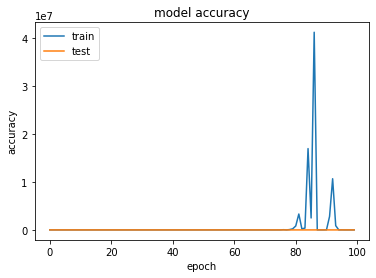

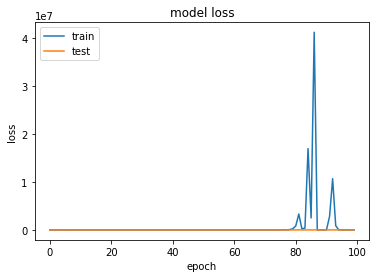

In [144]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [145]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

7.211532201655707
5.472334649603271
41.714212722472965


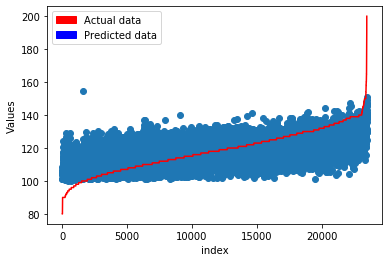

,t + 1,pred (t +1),diff
13044,80.0,104.974762,24.974762
2481,80.0,101.413292,21.413292
2019,82.0,108.596695,26.596695
14306,85.0,105.688011,20.688011
7511,88.0,101.242935,13.242935
3649,89.0,106.611969,17.611969
4750,89.0,103.507233,14.507233
5429,89.0,104.798561,15.798561
18369,89.0,101.271683,12.271683
8046,90.0,101.259949,11.259949


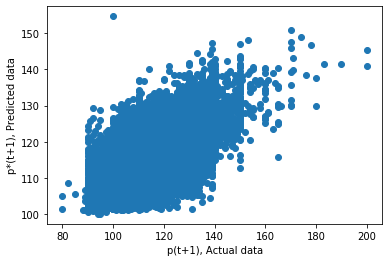

In [146]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)